<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Dask Arrays - parallelized numpy
Parallel, larger-than-memory, n-dimensional array using blocked algorithms. 

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations.


<img src="https://docs.dask.org/en/stable/_images/dask-array.svg" width="40%" align="right">


In other words, Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.

In this notebook, we'll build some understanding by implementing some blocked algorithms from scratch.
We'll then use Dask Array to analyze large datasets, in parallel, using a familiar NumPy-like API.

**Related Documentation**

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

## Create datasets

Create the datasets you will be using in this notebook:

In [1]:
%run prep.py -d random

- Generating random array data... 

## Start the Client

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 6.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36973,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 6.78 GiB
Comm: tcp://127.0.0.1:46023,Total threads: 1
Dashboard: http://127.0.0.1:43131/status,Memory: 1.70 GiB
Nanny: tcp://127.0.0.1:43311,


## Blocked Algorithms in a nutshell

Let's do side by side the sum of the elements of an array using a NumPy array and a Dask array. 

In [3]:
import numpy as np
import dask.array as da

In [4]:
#NumPy array
a_np = np.ones(10)
a_np

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We know that we can use `sum()` to compute the sum of the elements of our array, but to show what a blocksized operation would look like, let's do:

In [5]:
a_np_sum = a_np[:5].sum() + a_np[5:].sum() 
a_np_sum

10.0

Now notice that each sum in the computation above is completely independent so they could be done in parallel. 
To do this with Dask array, we need to define our "slices", we do this by defining the amount of elements we want per block using the variable `chunks`. 

In [6]:
a_da = da.ones(10, chunks=5)
a_da

dask.array<ones_like, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

**Important!**

Note here that to get two blocks, we specify `chunks=5`, in other words, we have 5 elements per block. 

In [7]:
a_da_sum = a_da.sum()
a_da_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

## Task Graphs

In general, the code that humans write rely on compilers or interpreters so the computers can understand what we wrote. When we move to parallel execution there is a desire to shift responsibility from the compilers to the human, as they often bring the analysis, optimization, and execution of code into the code itself. In these cases, we often represent the structure of our program explicitly as data within the program itself.

In Dask we use task scheduling, where we break our program into into many medium-sized tasks or units of computation.We represent these tasks as nodes in a graph with edges between nodes if one task depends on data produced by another. We call upon a task scheduler to execute this graph in a way that respects these data dependencies and leverages parallelism where possible, so multiple independent tasks can be run simultaneously.

In [8]:
# visualize the low level Dask graph using cytoscape
a_da_sum.visualize(engine="cytoscape")


CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [9]:
a_da_sum.compute()

10.0

Performance comparison
------------------------------

Let's try a more interesting example. We will create a 20_000 x 20_000 array with normally distributed values, and take the mean along one of its axis.

**Note:**

If you are running on Binder, the Numpy example might need to be a smaller one due to memory issues. 

### Numpy version 

In [10]:
%%time 
xn = np.random.normal(10, 0.1, size=(30_000, 30_000)) 
yn = xn.mean(axis=0)
yn

CPU times: user 29.4 s, sys: 15.9 s, total: 45.4 s
Wall time: 2min 9s


array([10.0002484 , 10.00046351, 10.00016063, ..., 10.00059708,
       10.00020041, 10.00072354])

### Dask array version

In [11]:
xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000))
xd

dask.array<normal, shape=(30000, 30000), dtype=float64, chunksize=(3000, 3000), chunktype=numpy.ndarray>

In [12]:
xd.nbytes / 1e9  # Gigabytes of the input processed lazily

7.2

In [13]:
yd = xd.mean(axis=0) 
yd

dask.array<mean_agg-aggregate, shape=(30000,), dtype=float64, chunksize=(3000,), chunktype=numpy.ndarray>

In [14]:
%%time
xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000))
yd = xd.mean(axis=0) 
yd.compute() 

CPU times: user 830 ms, sys: 221 ms, total: 1.05 s
Wall time: 17.3 s


array([10.00029979,  9.99987353, 10.00001138, ...,  9.99946041,
       10.00066961,  9.9993156 ])

**Questions to think about:**

* What happens if the Dask chunks=(10000,10000)?
* What happens if the Dask chunks=(30,30)?

**Exercise:** 

For Dask arrays, compute the mean along `axis=1` of the sum of the x array and its transpose. 

**Solution**

In [15]:
x_sum = xd + xd.T 
res = x_sum.mean(axis=1)
res.compute()

array([19.99996827, 19.9996882 , 20.00018783, ..., 19.99947477,
       20.00139932, 19.99932474])

## Choosing good chunk sizes
This section was inspired on a Dask blog by Genevieve Buckley you can read it [here](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)

A common problem when getting started with Dask array is determine what is a good chunk size. But what is a good size, and how do we determine this? 


### Get to know the chunks 

We can think of Dask arrays as a big structure composed by chunks of a smaller size, where these chunks are typically an a single `numpy` array, and they are all arranged to form a larger Dask array. 

If you have a Dask array and want to know more information about chunks and their size, you can use the `chunksize` and `chunks` attributes to access this information. If you are in a jupyter notebook
you can also visualize the Dask array via its HTML representation. 

In [16]:
darr = da.random.random((1000, 1000, 1000))
darr

dask.array<random_sample, shape=(1000, 1000, 1000), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

Notice that when we created the Dask array, we did not specify the `chunks`. Dask has set by default `chunks='auto'` which accommodates ideal chunk  sizes. To learn more on how auto-chunking works you can go to this documentation https://docs.dask.org/en/stable/array-chunks.html#automatic-chunking

`darr.chunksize` shows the largest chunk size. If you expect your array to have uniform chunk sizes this is a a good summary of the chunk size information. But if your array have irregular chunks, `darr.chunks` will show you the explicit sizes of all the chunks along all the dimensions of your dask array.

In [17]:
darr.chunksize

(250, 250, 250)

In [18]:
darr.chunks

((250, 250, 250, 250), (250, 250, 250, 250), (250, 250, 250, 250))

Let's modify our example to see explore chunking a bit more. We can rechunk our array:

In [19]:
darr = darr.rechunk({0: -1, 1: 100, 2: 'auto'})

In [20]:
darr

dask.array<rechunk-merge, shape=(1000, 1000, 1000), dtype=float64, chunksize=(1000, 100, 125), chunktype=numpy.ndarray>

In [21]:
darr.chunksize

(1000, 100, 125)

In [22]:
darr.chunks

((1000,),
 (100, 100, 100, 100, 100, 100, 100, 100, 100, 100),
 (125, 125, 125, 125, 125, 125, 125, 125))

**Exercise:**

- What does -1 do when specify as the chunk on a certain axis?

### Too small is a problem

If your chunks are too small, the amount of actual work done by every task is very tiny, and the overhead of coordinating all these tasks results in a very inefficient process. 

In general, the dask scheduler takes approximately one millisecond to coordinate a single task. That means we want the computation time to be comparatively large, i.e in the order of seconds. 

Intuitive analogy by Genevieve Buckley:

> Lets imagine we are building a house. It is a pretty big job, and if there were only one worker it would take much too long to build. So we have a team of workers and a site foreman. The site foreman is equivalent to the Dask scheduler: their job is to tell the workers what tasks they need to do.  
Say we have a big pile of bricks to build a wall, sitting in the corner of the building site. If the foreman (the Dask scheduler) tells workers to go and fetch a single brick at a time, then bring each one to where the wall is being built, you can see how this is going to be very slow and inefficient! The workers are spending most of their time moving between the wall and the pile of bricks. Much less time is going towards doing the actual work of mortaring bricks onto the wall.  
Instead, we can do this in a smarter way. The foreman (Dask scheduler) can tell the workers to go and bring one full wheelbarrow load of bricks back each time. Now workers are spending much less time moving between the wall and the pile of bricks, and the wall will be finished much quicker. 

### Too big is a problem

If your chunks are too big, this is also a problem because you will likely run out of memory. You will start seeing in the dashboard that data is being spill to disk and this will lead to performance decrements. 

If we load to much data into memory, Dask workers will start to spill data to disk to avoid crashing. Spilling data to disk will slow things down significantly, because of all the extra read and write operations to disk. This is definitely a situation that we want to avoid, to watch out for this you can look at the worker memory plot on the dashboard. Orange bars are a warning you are close to the limit, and gray means data is being spilled to disk. 

To watch out for this, look at the worker memory plot on the Dask dashboard. Orange bars are a warning you are close to the limit, and gray means data is being spilled to disk - not good! For more tips, see the section on using the Dask dashboard below. To learn more about the memory plot, check the [dashboard documentation](https://docs.dask.org/en/stable/dashboard.html#bytes-stored-and-bytes-per-worker).


### Rules of thumb

- Users have reported that chunk sizes smaller than 1MB tend to be bad. In general, a chunk size between **100MB and 1GB is good**, while going over 1 or 2GB means you have a really big dataset and/or a lot of memory available per worker.
- Upper bound: Avoid very large task graphs. More than 10,000 or 100,000 chunks may start to perform poorly.
- Lower bound: To get the advantage of parallelization, you need the number of chunks to at least equal the number of worker cores available (or better, the number of worker cores times 2). Otherwise, some workers will stay idle.
- The time taken to compute each task should be much larger than the time needed to schedule the task. The Dask scheduler takes roughly 1 millisecond to coordinate a single task, so a good task computation time would be in the order of seconds (not milliseconds).
- Chunks should be aligned with array storage on disk. Modern NDArray storage formats (HDF5, NetCDF, TIFF, Zarr) allow arrays to be stored in chunks so that the blocks of data can be pulled efficiently. However, data stores often chunk more finely than is ideal for Dask array, so it is common to choose a chunking that is a multiple of your storage chunk size, otherwise you might incur high overhead. For example,  if you are loading data that is chunked in blocks of (100, 100), the  you might might choose a chunking strategy more like (1000, 2000) that is larger but still divisible by (100, 100). 

For more more advice on chunking see https://docs.dask.org/en/stable/array-chunks.html

## Example of chunked data with Zarr

Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. Zarr provides classes and functions for working with N-dimensional arrays that behave like NumPy arrays (Dask array behave like Numpy arrays) but whose data is divided into chunks and each chunk is compressed. If you are already familiar with HDF5 then Zarr arrays provide similar functionality, but with some additional flexibility.

For extra material check the [Zarr tutorial](https://zarr.readthedocs.io/en/stable/tutorial.html)

**Let's read an array from zarr:**

In [23]:
import zarr

In [24]:
a = da.from_zarr("data/random.zarr")

In [25]:
a

dask.array<from-zarr, shape=(20000000,), dtype=float64, chunksize=(625000,), chunktype=numpy.ndarray>

Notice that the array is already chunked, and we didn't specify anything when loading it. Now notice that the chunks have a nice chunk size, let's compute the mean and see how long it takes to run

In [26]:
%%time
a.mean().compute()

CPU times: user 249 ms, sys: 46.5 ms, total: 295 ms
Wall time: 5.9 s


0.5000543902696587

Let's load a separate example where the `chunksize` is much smaller, and see what happen

In [27]:
b = da.from_zarr("data/random_sc.zarr")
b

dask.array<from-zarr, shape=(20000000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [28]:
%%time
b.mean().compute()

CPU times: user 18.5 s, sys: 1.04 s, total: 19.5 s
Wall time: 41.6 s


0.5000922894765777

### Exercise:

Provide a `chunksize` when reading `b` that will improve the time of computation of the mean. Try multiple `chunks` values and see what happens.

In [29]:
# 1 possible Solution (imitate original). chunks will vary if you are in binder
c = da.from_zarr("data/random_sc.zarr", chunks=(6250000, ))
c

dask.array<from-zarr, shape=(20000000,), dtype=float64, chunksize=(6250000,), chunktype=numpy.ndarray>

In [30]:
%%time
c.mean().compute()

CPU times: user 401 ms, sys: 33.7 ms, total: 434 ms
Wall time: 3.38 s


0.5000922894765777

## Xarray  

In some applications we have multidimensional data, and sometimes working with all this dimensions can be confusing. Xarray is an open source project and Python package that makes working with labeled multi-dimensional arrays easier. 

Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labeled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with Dask for parallel computing.

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. 

Let's learn how to use xarray and Dask together:


In [31]:
import xarray as xr

In [32]:
ds = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={  # this tells xarray to open the dataset as a dask array
        "lat": 25,
        "lon": 25,
        "time": -1,
    },
)
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [33]:
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-b91dfd766613ef8ef89496d674c487fcair, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [34]:
ds.air.chunks

((2920,), (25,), (25, 25, 3))

In [35]:
mean = ds.air.mean("time")  # no activity on dashboard
mean  # contains a dask array

<xarray.DataArray 'air' (lat: 25, lon: 53)>
dask.array<mean_agg-aggregate, shape=(25, 53), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

In [36]:
#we will see dashboard activity
mean.load()

<xarray.DataArray 'air' (lat: 25, lon: 53)>
array([[260.37564, 260.1826 , 259.88593, ..., 250.81511, 251.93733,
        253.43741],
       [262.7337 , 262.7936 , 262.7489 , ..., 249.75496, 251.5852 ,
        254.35849],
       [264.7681 , 264.3271 , 264.0614 , ..., 250.60707, 253.58247,
        257.71475],
       ...,
       [297.64932, 296.95294, 296.62912, ..., 296.81033, 296.28793,
        295.81622],
       [298.1287 , 297.93646, 297.47006, ..., 296.8591 , 296.77686,
        296.44348],
       [298.36594, 298.38593, 298.11386, ..., 297.33777, 297.28104,
        297.30502]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

### Standard Xarray Operations

Let's grab the air variable and do some operations. Operations using xarray objects are identical, regardless if the underlying data is stored as a Dask array or a NumPy array.

In [37]:
dair = ds.air

In [38]:
dair2 = dair.groupby('time.month').mean('time')
dair_new = dair - dair2
dair_new

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)>
dask.array<sub, shape=(2920, 25, 53, 12), dtype=float32, chunksize=(2920, 25, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Call `.compute()` or `.load()` when you want your result as a `xarray.DataArray` with data stored as NumPy arrays.

In [39]:
#things happen in the dashboard
dair_new.load()

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)>
array([[[[-5.14987183e+00, -5.47715759e+00, -9.83168030e+00, ...,
          -2.06136017e+01, -1.25448456e+01, -6.77099609e+00],
         [-3.88607788e+00, -3.90576172e+00, -8.17987061e+00, ...,
          -1.87125549e+01, -1.11448669e+01, -5.52117920e+00],
         [-2.71517944e+00, -2.44839478e+00, -6.68945312e+00, ...,
          -1.70036011e+01, -9.99716187e+00, -4.41302490e+00],
         ...,
         [-1.02611389e+01, -9.05839539e+00, -9.39399719e+00, ...,
          -1.53933716e+01, -1.01606750e+01, -6.97190857e+00],
         [-8.58795166e+00, -7.50210571e+00, -7.61483765e+00, ...,
          -1.35699463e+01, -8.43449402e+00, -5.52383423e+00],
         [-7.04670715e+00, -5.84384155e+00, -5.70956421e+00, ...,
          -1.18162537e+01, -6.54209900e+00, -4.02824402e+00]],

        [[-5.05761719e+00, -4.00010681e+00, -9.17195129e+00, ...,
          -2.52222595e+01, -1.53296814e+01, -5.93362427e+00],
         [-4.40733337e+00, -3.25991821e+00, -8.36616516e+00, ...,
          -2.44294434e+01, -1.41292725e+01, -5.66036987e+00],
         [-4.01040649e+00, -2.77757263e+00, -7.87347412e+00, ...,
          -2.40147858e+01, -1.34914398e+01, -5.78581238e+00],
...
          -3.56890869e+00, -2.47412109e+00, -1.16558838e+00],
         [ 6.08795166e-01,  1.47219849e+00,  1.11965942e+00, ...,
          -3.59872437e+00, -2.50396729e+00, -1.15667725e+00],
         [ 6.59942627e-01,  1.48742676e+00,  1.03787231e+00, ...,
          -3.84628296e+00, -2.71829224e+00, -1.33132935e+00]],

        [[ 5.35827637e-01,  4.01092529e-01,  3.08258057e-01, ...,
          -1.68054199e+00, -1.12142944e+00, -1.90887451e-01],
         [ 8.51684570e-01,  8.73504639e-01,  6.26892090e-01, ...,
          -1.33462524e+00, -7.66601562e-01,  1.03210449e-01],
         [ 1.04107666e+00,  1.23202515e+00,  8.63311768e-01, ...,
          -1.06607056e+00, -5.31036377e-01,  3.14453125e-01],
         ...,
         [ 4.72015381e-01,  1.32940674e+00,  1.15509033e+00, ...,
          -3.23403931e+00, -2.23956299e+00, -1.11035156e+00],
         [ 4.14459229e-01,  1.23419189e+00,  1.07876587e+00, ...,
          -3.47311401e+00, -2.56188965e+00, -1.37548828e+00],
         [ 5.35278320e-02,  8.10333252e-01,  6.73461914e-01, ...,
          -4.07232666e+00, -3.12890625e+00, -1.84762573e+00]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Time Series Operations with xarray

Because we have a datetime index time-series operations work efficiently, for example we can do a resample and then plot the result.

In [40]:
dair_resample = dair.resample(time='1w').mean('time').std('time')

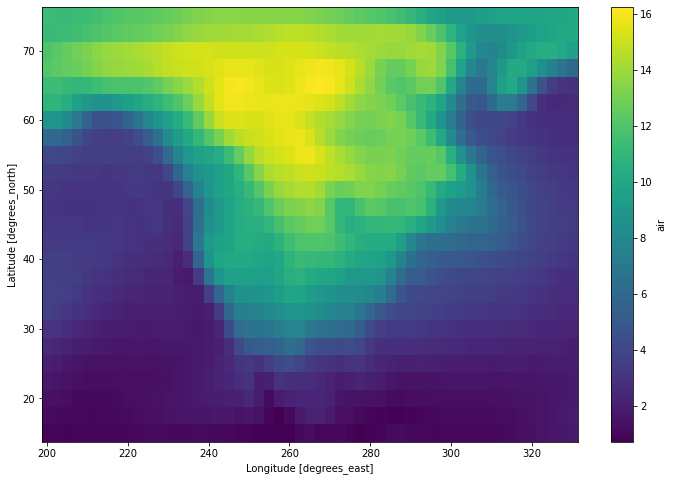

In [41]:
dair_resample.load().plot(figsize=(12, 8))

### Learn More 

Both xarray and zarr have their own tutorials that go into greater depth:

* [Zarr tutorial](https://zarr.readthedocs.io/en/stable/tutorial.html)
* [Xarray tutorial](https://tutorial.xarray.dev/intro.html)

## Close your cluster

It's good practice to close any Dask cluster you create:

In [42]:
client.shutdown()